In [236]:
# imports
import pandas as pd

In [237]:
df_training = pd.read_csv("./kaggle/input/forest-fire-prediction-epoch-hackathon/wildfire_sizes_before_2010.csv")
df_states = pd.read_csv("./kaggle/input/forest-fire-prediction-epoch-hackathon/merged_state_data.csv")
df_weather = pd.read_csv("./kaggle/input/forest-fire-prediction-epoch-hackathon/weather_monthly_state_aggregates.csv")
df_existing_states = pd.read_csv('./kaggle/input/states.csv')

df_weather.head()
df_training.head()

,STATE,month,total_fire_size
0,AK,1992-04,10.1
1,AK,1992-05,4309.5
2,AK,1992-06,86460.6
3,AK,1992-07,48578.5
4,AK,1992-08,3321.8


In [238]:
def augment_df(df, df_states, df_weather):
    df.rename(columns={
        'STATE': 'State',
        'month': 'year_month'
    }, inplace=True)

    # Merge the datasets.
    df = pd.merge(df, df_states, 'left', on='State')
    df = pd.merge(df, df_weather, 'left', on=['State', 'year_month'])
    # For now it looks like only the weather data is incomplete.
    # Just drop it. We could take monthly average from the year before or something like that...
    # Not feeling like aggregating rn.
    df.dropna(inplace=True)
    # Or impute with state-specific mean/median
    df['year_month'] = pd.to_datetime(df['year_month'])

    df['Percentage of Federal Land'] = df['Percentage of Federal Land'].str.rstrip('%').astype(float) / 100
    df['Urbanization Rate (%)'] = df['Urbanization Rate (%)'] / 100
    return df

df_training = augment_df(df_training, df_states, df_weather)

In [239]:
# Assert that every measurement is in correct format and dtype.

# Assert the every state exists.

def assert_df(df):
    
    assert df['State'].isin(df_existing_states['Abbreviation']).all(), "Invalid state abbreviation(s) found!"
    # date_pattern = r'^\d{4}-\d{2}$'
    # assert df['year_month'].astype(str).str.match(date_pattern).all(), "Invalid date format found!"
    assert (df['total_fire_size'] >= 0).all(), "Found negative value in total_fire_size!"
    assert (df['mean_elevation'] >= 0).all(), 'mean_elevation'
    assert (df['Land Area (sq mi)'] >= 0).all(), 'land area'
    assert (df['Water Area (sq mi)'] >= 0).all(), 'Water Area'
    assert (abs(df['Land Area (sq mi)'] + df['Water Area (sq mi)'] - df['Total Area (sq mi)']) <= 1).all(), "Mismatch found in area calculation!"
    assert not df['Percentage of Federal Land'].isna().any(), 'percentage'
    assert (df['PRCP'] >= 0).all(), 'PRCP'

# I guess EVAP can be any value.
# I have no idea what these measurements are. They seem very broken...
# Nonetheless, let's continue.
# assert_df(df_training)

In [240]:
def augment_features(df):
    # Create a new features vector.
    df_features = pd.DataFrame()
    # Create a seperate feature for month and years, because this might indicate season.
    df_features['total_fire_size'] = df['total_fire_size']
    df_features['State'] = df['State']

    df_features['Year'] = df['year_month'].dt.year
    df_features['Month'] = df['year_month'].dt.month

    df_features['TotalArea'] = df['Total Area (sq mi)']

    df_features['MeanElevation'] = df['mean_elevation']

    df_features['LandArea'] = df['Land Area (sq mi)']
    df_features['AreaWater'] = df['Water Area (sq mi)']
    df_features['WaterLandRatio'] = df['Water Area (sq mi)'] / df['Land Area (sq mi)']

    df_features['FederalLandRatio'] = df['Percentage of Federal Land']
    df_features['UrbanizationRatio'] = df['Urbanization Rate (%)']

    df_features['PRCP'] = df['PRCP']
    df_features['EVAP'] = df['EVAP']

    df_features['PRCPEVAPRatio'] = (df['PRCP'] / df['EVAP']).where(df['EVAP'] != 0)

    # print(df_features[df_features['PRCPEVAPRatio'].isna()])
    # # We shouldnt really fill these...
    df_features['PRCPEVAPRatio'] = df_features['PRCPEVAPRatio'].fillna(0)


    df_features['TMIN'] = df['TMIN']
    df_features['TMAX'] = df['TMAX']
    df_features['TDELTA'] = df['TMAX'] - df['TMIN']

    assert not df_features.isna().any().any(), 'There are missing values in the features dataframe.'
    missing_values = df_features.isna().sum()

    return df_features

df_features = augment_features(df_training)

In [241]:
from sklearn.preprocessing import StandardScaler

def preprocess(df, scaler=None, fit_scaler=True):
    numeric_features = df.columns[df.columns != 'State']

    # Standardize numeric features
    if scaler is None:
        scaler = StandardScaler()

    if fit_scaler:
        df[numeric_features] = scaler.fit_transform(df[numeric_features])
    else:
        df[numeric_features] = scaler.transform(df[numeric_features])

    all_states = df_existing_states['Abbreviation'].unique()

    # Apply one-hot encoding
    df = pd.get_dummies(df, columns=['State'])

    # Ensure all states are represented in the dummy variables
    for state in all_states:
        state_col = f"State_{state}"
        if state_col not in df.columns:
            df[state_col] = 0  # Fill missing states with 0

    y = df['total_fire_size']
    X = df.drop('total_fire_size', axis=1)

    return X, y, scaler


X, y, scaler = preprocess(df_features)
X


,Year,Month,TotalArea,MeanElevation,LandArea,AreaWater,WaterLandRatio,FederalLandRatio,UrbanizationRatio,PRCP,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
1,-1.668394,-0.658733,6.720662,0.060744,6.341242,7.225844,0.460698,2.07182,-0.672231,-1.014453,...,False,False,False,False,False,False,False,False,False,False
2,-1.668394,-0.302616,6.720662,0.060744,6.341242,7.225844,0.460698,2.07182,-0.672231,-0.459948,...,False,False,False,False,False,False,False,False,False,False
3,-1.668394,0.053501,6.720662,0.060744,6.341242,7.225844,0.460698,2.07182,-0.672231,-0.284067,...,False,False,False,False,False,False,False,False,False,False
4,-1.668394,0.409619,6.720662,0.060744,6.341242,7.225844,0.460698,2.07182,-0.672231,-0.688274,...,False,False,False,False,False,False,False,False,False,False
5,-1.668394,0.765736,6.720662,0.060744,6.341242,7.225844,0.460698,2.07182,-0.672231,-0.254008,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,1.620926,-0.658733,0.168487,2.774367,0.244878,-0.356999,-0.565513,1.39362,-0.896579,-1.185857,...,False,False,False,False,False,False,False,False,False,True
9614,1.620926,-0.302616,0.168487,2.774367,0.244878,-0.356999,-0.565513,1.39362,-0.896579,0.221190,...,False,False,False,False,False,False,False,False,False,True
9615,1.620926,0.053501,0.168487,2.774367,0.244878,-0.356999,-0.565513,1.39362,-0.896579,-0.977997,...,False,False,False,False,False,False,False,False,False,True
9616,1.620926,0.409619,0.168487,2.774367,0.244878,-0.356999,-0.565513,1.39362,-0.896579,-0.746474,...,False,False,False,False,False,False,False,False,False,True


In [247]:
# Train
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_split=10, max_depth=20)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=200,
                      random_state=42)

In [249]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.17170996152783766
Mean Squared Error: 0.6639315999389558
R-squared: 0.2715456942255099


In [250]:
# Check feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances and their names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on importance in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

sorted_feature_importance[:20]

,Feature,Importance
10,EVAP,0.188888
13,TMAX,0.161950
11,PRCPEVAPRatio,0.111442
9,PRCP,0.093676
12,TMIN,0.087125
0,Year,0.068528
14,TDELTA,0.050977
2,TotalArea,0.045690
5,AreaWater,0.042082
4,LandArea,0.034991


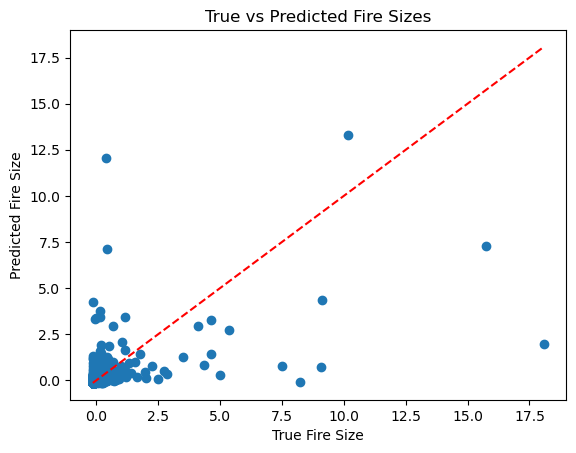

In [245]:
import matplotlib.pyplot as plt

# Plot true values vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Fire Size')
plt.ylabel('Predicted Fire Size')
plt.title('True vs Predicted Fire Sizes')

# Set logarithmic scale for both axes

# Add the target line where x = y
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()



In [246]:
def paramsweep():
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'n_estimators': [50, 100, 150, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],  # You could also tune other parameters like max_depth
        'min_samples_split': [2, 5, 10]  # Another hyperparameter you can try
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=5,  # Cross-validation, you can adjust this based on your data size
                            n_jobs=-1,  # Use all CPU cores
                            verbose=2)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters found
    print(f"Best Parameters: {grid_search.best_params_}")

    # Best model
    best_model = grid_search.best_estimator_

# You can now use this model to predict and evaluate.

paramsweep()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


In [233]:
# Generate the date range from 2011-01 to 2015-12 for each state
date_range = pd.date_range(start='2011-01-01', end='2015-12-31', freq='ME')

# Create an empty list to hold the data
data = []

# Iterate over each state and month to create rows
for state in df_existing_states['Abbreviation']:
    for date in date_range:
        row = {
            'STATE': state,
            'month': date.strftime('%Y-%m'),
            'total_fire_size': 0.0
        }
        data.append(row)

# Create the dataframe
df_submission = pd.DataFrame(data)
df_submission = augment_df(df_submission, df_states, df_weather)
assert_df(df_submission)

df_f = augment_features(df_submission)

X_t, y_t, _ = preprocess(df_f, scaler)

X_t = X_t.reindex(columns=X.columns, fill_value=0)

y_pred = model.predict(X_t)

df_submission['total_fire_size'] = y_pred

In [234]:

# add ID column that kaggle wants (order does not matter though, items are match by (STATE, month) pair)
df_submission['ID'] = range(len(df_submission))

# order columns
df_export = df_submission[['ID', 'State', 'year_month', 'total_fire_size']]
df_export = df_export.rename(columns={
    'State': 'STATE',
    'year_month': 'month'
})
df_export.to_csv('submission.csv', index=False)
df_export

,ID,STATE,month,total_fire_size
0,0,AL,2011-01-01,-0.032503
1,1,AL,2011-02-01,-0.021659
2,2,AL,2011-03-01,-0.052662
3,3,AL,2011-04-01,-0.067919
4,4,AL,2011-05-01,-0.111815
...,...,...,...,...
2992,2155,WY,2015-05-01,-0.136243
2993,2156,WY,2015-06-01,-0.085813
2994,2157,WY,2015-07-01,-0.084327
2995,2158,WY,2015-08-01,-0.083495
